In [1]:
import sys
sys.path.insert(0, '..')
# Allows plots to be zoomed in, etc
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import time

from Configuration import Configuration
from InterneuronPoolOpt import InterneuronPool
from SynapsesFactory import SynapsesFactory

In [45]:
def simulator(numberRC, duration, current, am, bm, ah, bh, an, bn, aq, bq):

    conf = Configuration('confuchiyama.rmto')

    # Number of cells
    idx = np.where(conf.confArray['f0']=='Number_RC_ext')[0][0]
    conf.confArray['f1'][idx] = numberRC
    
    # Duration of simulation
    conf.simDuration_ms = duration
    
    idx = np.where(conf.confArray['f0']=='threshold:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 27.01271
    conf.confArray['f2'][idx] = 27.01271

    # Ks
    idx = np.where(conf.confArray['f0']=='gmax_Ks:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = 1000
    idx = np.where(conf.confArray['f0']=='alpha_m:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = am
    idx = np.where(conf.confArray['f0']=='beta_m:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = bm
    idx = np.where(conf.confArray['f0']=='alpha_h:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = ah
    idx = np.where(conf.confArray['f0']=='beta_h:RC_ext-@soma')[0][0]
    conf.confArray['f1'][idx] = bh

    ## Morphology
    idx = np.where(conf.confArray['f0']=='d@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 27
    conf.confArray['f2'][idx] = 27
    idx = np.where(conf.confArray['f0']=='l@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 218.2168
    conf.confArray['f2'][idx] = 218.2168
    idx = np.where(conf.confArray['f0']=='res@soma:RC_ext-')[0][0]
    conf.confArray['f1'][idx] = 10000
    conf.confArray['f2'][idx] = 10000
    
    pools = dict()
    pools[0] = InterneuronPool(conf, 'RC', 'ext')

    Syn = SynapsesFactory(conf, pools)

    t = np.arange(0.0, conf.simDuration_ms, conf.timeStep_ms)

    RC_mV = np.zeros_like(t)
    for i in xrange(0, len(t)):
        if t[i]>10 and t[i]<11:
            for j in xrange(len(pools[0].unit)):
                pools[0].iInjected[j] = current
        else:
            for j in xrange(len(pools[0].unit)):
                pools[0].iInjected[j] = 0
        #pools[1].atualizePool(t[i]) # RC synaptic Noise
        pools[0].atualizeInterneuronPool(t[i]) # RC pool
        RC_mV[i] = pools[0].unit[0].v_mV[0]

    pools[0].listSpikes()

    return RC_mV, t

In [52]:
nRC = 1
t = 100
i = 6
am=22
bm=13
ah=0.5
bh=4
an=1.5
bn=0.1
aq=1.5
bq=0.075

RCMembrane, t = simulator(nRC, t, i, am, bm, ah, bh, an, bn, aq, bq)

Interneuron Pool of RC ext built
All the 0 synapses were built
Synaptic Noise on RC_ext built
All the 1 synaptic noises were built


<IPython.core.display.Javascript object>


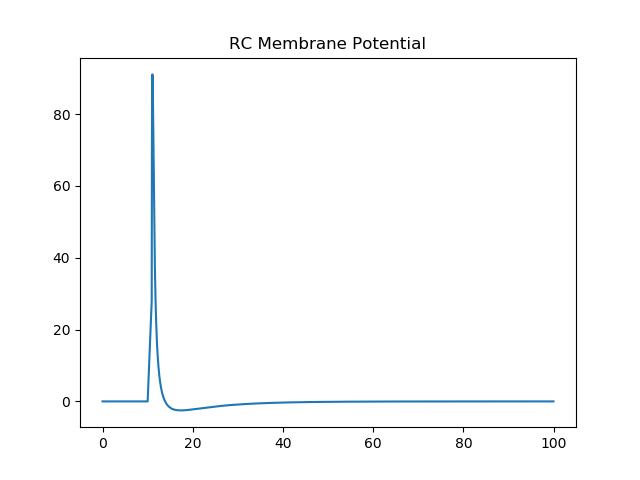

In [53]:
plt.figure()
plt.plot(t, RCMembrane)
plt.title('RC Membrane Potential')
plt.show()